In [1]:
import time
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
GPU = 0
device = torch.device("cuda:{}".format(GPU)) if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Param list
EPOCH = 300
TIMESTEP = 12
TRAINDAYS = 30

OPTIMIZER = 'Adam'
LEARN = 0.0001
PATIENCE = 20
beijing = None
changchun = None
shenzhen = None
shanghai = None
Loss = nn.L1Loss()
scaler_dict = dict()
model_dict = dict()
scaler_x = StandardScaler()

In [3]:
def csv_to_tensor(file):
    Data = pd.read_csv(file)
    scaler = StandardScaler()
    scaler_dict[file.split('/')[2][0:-9]] = scaler
    f = Data['confirmedNum'].to_numpy()[::-1].reshape(42, 1).astype(float)
    f = scaler.fit_transform(f)
    x_data = np.arange(0, 42, 1)
    x_data = x_data.reshape(-1, 1).astype(int)
    x_data = scaler_x.fit_transform(x_data)
    data = np.append(x_data, values=f, axis=1)
    d = torch.from_numpy(data.copy())
    return d


In [4]:
def read_csv_to_list():
    global beijing
    global shenzhen
    global changchun
    global shanghai
    beijing = csv_to_tensor('./input/beijing_data.csv')
    shenzhen = csv_to_tensor('./input/shenzhen_data.csv')
    changchun = csv_to_tensor('./input/changchun_data.csv')
    shanghai = csv_to_tensor('./input/shanghai_data.csv')


read_csv_to_list()

In [5]:
shenzhen

tensor([[-1.6913, -1.3168],
        [-1.6088, -1.2994],
        [-1.5263, -1.2835],
        [-1.4438, -1.2739],
        [-1.3613, -1.2517],
        [-1.2788, -1.2184],
        [-1.1963, -1.1961],
        [-1.1138, -1.1739],
        [-1.0313, -1.1358],
        [-0.9488, -1.0913],
        [-0.8663, -1.0532],
        [-0.7838, -0.9977],
        [-0.7013, -0.9468],
        [-0.6188, -0.8500],
        [-0.5363, -0.7706],
        [-0.4538, -0.6420],
        [-0.3713, -0.5467],
        [-0.2888, -0.3593],
        [-0.2063, -0.2244],
        [-0.1238, -0.1021],
        [-0.0413, -0.0180],
        [ 0.0413,  0.0614],
        [ 0.1238,  0.1107],
        [ 0.2063,  0.1678],
        [ 0.2888,  0.2393],
        [ 0.3713,  0.3155],
        [ 0.4538,  0.4378],
        [ 0.5363,  0.5981],
        [ 0.6188,  0.6839],
        [ 0.7013,  0.7934],
        [ 0.7838,  0.9252],
        [ 0.8663,  1.0475],
        [ 0.9488,  1.1364],
        [ 1.0313,  1.2460],
        [ 1.1138,  1.3031],
        [ 1.1963,  1

In [6]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.__padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self, in_channels=1, embedding_size=256, k=5):
        super(context_embedding, self).__init__()
        self.causal_convolution = CausalConv1d(in_channels, embedding_size, kernel_size=k)

    def forward(self, x):
        x = self.causal_convolution(x)
        return torch.tanh(x)


class Transformer(nn.Module):
    def __init__(self, device=device, dmodel=256):
        super(Transformer, self).__init__()
        self.input_embedding = context_embedding(2, dmodel,5)
        self.positional_embedding = torch.nn.Embedding(TIMESTEP, dmodel)
        self.device = device
        self.dmodel = dmodel
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=dmodel, nhead=4)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=6)
        self.fc1 = torch.nn.Linear(dmodel, int(dmodel / 2))
        self.fc12 = torch.nn.Linear(int(dmodel / 2), 1)
        self.fc2 = torch.nn.Linear(TIMESTEP, 1)

    def forward(self, x, y, attention_mask):
        z = torch.cat((y.unsqueeze(1), x.unsqueeze(1)), 1)
        z_embedding = self.input_embedding(z).permute(2, 0, 1)
        positional_embeddings = self.positional_embedding(torch.arange(0, TIMESTEP).to(self.device)).expand(1, TIMESTEP,
                                                                                                            self.dmodel).permute(
            1, 0, 2)

        input_embedding = z_embedding + positional_embeddings
        transformer_embedding = self.transformer_decoder(input_embedding, attention_mask)

        output = self.fc1(transformer_embedding.permute(1, 0, 2))
        output = self.fc12(output).permute(2, 0, 1)
        output = self.fc2(output)
        return output

In [7]:
def evaluate_epoch(model, name,test):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for i in range(0, TIMESTEP):
            x = test[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 0].reshape(1, -1).float()
            y = test[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            # y_pred = model(x.cuda())[0][0]
            loss = Loss(y_pred.float(), test[i + TRAINDAYS][1].cuda().float())
            l_sum += loss.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n


In [8]:
def train(model, name, data):
    print('Model Training Started ...', time.ctime())
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARN)
    min_val_loss = np.inf
    for epoch in range(EPOCH):
        starttime = datetime.now()
        model.train()
        loss_sum, n = 0.0, 0
        for i in range(0, TRAINDAYS - TIMESTEP):
            optimizer.zero_grad()
            x = data[i:i + TIMESTEP, 0].reshape(1, -1).float()
            y = data[i:i + TIMESTEP, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            y = data[i + TIMESTEP][1]
            loss = Loss(y_pred.float(), y.cuda().float())
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            n += 1
        train_loss = loss_sum / n
        val_loss = evaluate_epoch(model,name, data)
        if val_loss < min_val_loss:
            wait = 0
            min_val_loss = val_loss
            open('./model/' + name + '.pt', 'a')
            torch.save(model.state_dict(), './model/' + name + '.pt')
        else:
            wait += 1
            if wait == PATIENCE:
                print('Early stopping at epoch: %d' % epoch)
                break
        endtime = datetime.now()
        epoch_time = (endtime - starttime).seconds
        print("epoch", epoch, "time used:", epoch_time, " seconds ", "train loss:", train_loss, "validation loss:",
              val_loss)
    print('Model Training Ended ...', time.ctime())

In [9]:
import Metrics


def test_model(model, name, data):
    loss = nn.L1Loss()
    print('Model Testing Started ...', time.ctime())
    model.load_state_dict(torch.load('./model/' + name + '.pt'))
    YS = data[30:42, 1]
    YS_pred = []
    scaler = scaler_dict[name]
    with torch.no_grad():

        for i in range(0, TIMESTEP):
            x = data[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 0].reshape(1, -1).float()
            y = data[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            YS_pred.append(y_pred.cpu())
    YS_pred = np.array(YS_pred)
    YS = scaler.inverse_transform(YS.reshape(-1,1))
    YS_pred = scaler.inverse_transform(YS_pred.reshape(-1,1))
    Mae = 0
    for i in range(TIMESTEP):
        MSE, RMSE, MAE, MAPE = Metrics.evaluate(YS[i], YS_pred[i])
        Mae += MAE
        print("%d step, %s, %s, MSE, RMSE, MAE, MAPE, %.10f, %.10f, %.10f, %.10f" % (
            i + 1, name, 'Transformer', MSE, RMSE, MAE, MAPE))
    print("Average MAE Loss is %.10f" % (Mae/TIMESTEP))
    print('Model Testing Ended ...', time.ctime())


In [10]:
# train every city
model = Transformer().cuda(device=device)
model_dict['shenzhen'] = model
train(model,'shenzhen',shenzhen)

Model Training Started ... Tue May 24 23:16:30 2022
epoch 0 time used: 3  seconds  train loss: 0.2924706004559994 validation loss: 1.055351326862971
epoch 1 time used: 0  seconds  train loss: 0.47096991166472435 validation loss: 1.0686987886826198
epoch 2 time used: 0  seconds  train loss: 0.4543788242671225 validation loss: 1.0783005903164546
epoch 3 time used: 0  seconds  train loss: 0.47439554292294717 validation loss: 1.0851181695858638
epoch 4 time used: 0  seconds  train loss: 0.4668850472403897 validation loss: 1.0906705756982167
epoch 5 time used: 0  seconds  train loss: 0.4560605486234029 validation loss: 1.0965147813161213
epoch 6 time used: 0  seconds  train loss: 0.44457272067666054 validation loss: 1.1020338932673137
epoch 7 time used: 0  seconds  train loss: 0.4634865460296472 validation loss: 1.1062071522076924
epoch 8 time used: 0  seconds  train loss: 0.4620044053428703 validation loss: 1.119966725508372
epoch 9 time used: 0  seconds  train loss: 0.45922130677435136 va

In [27]:
model = Transformer().cuda(device=device)
model_dict['shanghai'] = model
train(model,'shanghai',shanghai)

Model Training Started ... Tue May 24 23:48:17 2022
epoch 0 time used: 0  seconds  train loss: 0.32601879847546417 validation loss: 1.0478836248318355
epoch 1 time used: 0  seconds  train loss: 0.6011975266867213 validation loss: 1.0450361619393032
epoch 2 time used: 0  seconds  train loss: 0.5905564096238878 validation loss: 1.070509359240532
epoch 3 time used: 0  seconds  train loss: 0.5751640995343527 validation loss: 1.084003135561943
epoch 4 time used: 0  seconds  train loss: 0.5718076866534021 validation loss: 1.096714789668719
epoch 5 time used: 0  seconds  train loss: 0.5886244848370552 validation loss: 1.1185066401958466
epoch 6 time used: 0  seconds  train loss: 0.559377902911769 validation loss: 1.1170095304648082
epoch 7 time used: 0  seconds  train loss: 0.5595080380638441 validation loss: 1.0450210521618526
epoch 8 time used: 0  seconds  train loss: 0.500323192940818 validation loss: 0.6630648771921793
epoch 9 time used: 0  seconds  train loss: 0.505802783701155 validatio

In [12]:
model = Transformer().cuda(device=device)
model_dict['beijing'] = model
train(model,'beijing',beijing)

Model Training Started ... Tue May 24 23:17:15 2022
epoch 0 time used: 0  seconds  train loss: 0.1656358264800575 validation loss: 0.7761232008536657
epoch 1 time used: 0  seconds  train loss: 0.8612029718028175 validation loss: 1.2413293768962224
epoch 2 time used: 0  seconds  train loss: 0.6515559057394663 validation loss: 1.6023216843605042
epoch 3 time used: 0  seconds  train loss: 0.5379234453042349 validation loss: 1.6344479123751323
epoch 4 time used: 0  seconds  train loss: 0.5134059886137644 validation loss: 1.6119114061196644
epoch 5 time used: 0  seconds  train loss: 0.5182015713718202 validation loss: 1.5842793186505635
epoch 6 time used: 0  seconds  train loss: 0.5078682137860192 validation loss: 1.5361157258351643
epoch 7 time used: 0  seconds  train loss: 0.4892023669348823 validation loss: 1.3441843589146931
epoch 8 time used: 0  seconds  train loss: 0.3988753838671578 validation loss: 1.0803693781296413
epoch 9 time used: 0  seconds  train loss: 0.4725347210963567 vali

In [13]:
model = Transformer().cuda(device=device)
model_dict['changchun'] = model
train(model,'changchun',changchun)

Model Training Started ... Tue May 24 23:17:33 2022
epoch 0 time used: 0  seconds  train loss: 0.13284782899750602 validation loss: 0.09070658683776855
epoch 1 time used: 0  seconds  train loss: 0.6168408257265886 validation loss: 0.49963296949863434
epoch 2 time used: 0  seconds  train loss: 0.3206208472450574 validation loss: 0.5665864199399948
epoch 3 time used: 0  seconds  train loss: 0.41694260347220635 validation loss: 0.40994474788506824
epoch 4 time used: 0  seconds  train loss: 0.26487474102112984 validation loss: 0.030772477388381958
epoch 5 time used: 0  seconds  train loss: 0.47947244304749703 validation loss: 0.8897178669770559
epoch 6 time used: 0  seconds  train loss: 0.3980465547906028 validation loss: 0.5870650857686996
epoch 7 time used: 0  seconds  train loss: 0.19454323997100195 validation loss: 0.15435351431369781
epoch 8 time used: 0  seconds  train loss: 0.224117837432358 validation loss: 0.14804511765638986
epoch 9 time used: 0  seconds  train loss: 0.1742749690

In [14]:
test_model(model_dict['shenzhen'],'shenzhen',shenzhen)

Model Testing Started ... Tue May 24 23:17:48 2022
1 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 698.5735500008, 26.4305419922, 26.4305419922, 1.8718514159
2 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 1019.2009484917, 31.9249267578, 31.9249267578, 2.1440514948
3 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 859.1153140217, 29.3106689453, 29.3106689453, 1.8971306761
4 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 2304.6797376275, 48.0070800781, 48.0070800781, 2.9744163617
5 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 1623.9266789109, 40.2979736328, 40.2979736328, 2.4423014323
6 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 723.4865384698, 26.8977050781, 26.8977050781, 1.6067924180
7 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 217.9155483842, 14.7619628906, 14.7619628906, 0.8734889284
8 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 10.8227506280, 3.2897949219, 3.2897949219, 0.1936312491
9 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 

In [28]:
test_model(model_dict['shanghai'],'shanghai',shanghai)

Model Testing Started ... Tue May 24 23:50:16 2022
1 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 2283534.1827545166, 1511.1367187500, 1511.1367187500, 3.4168514420
2 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 368980.3164062500, 607.4375000000, 607.4375000000, 1.3344995386
3 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 15721039.1411743164, 3964.9765625000, 3964.9765625000, 7.7733969112
4 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 10853138.2776031494, 3294.4101562500, 3294.4101562500, 6.3042466201
5 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 5658228.5568847656, 2378.7031250000, 2378.7031250000, 4.4842271331
6 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 3255374.4455566406, 1804.2656250000, 1804.2656250000, 3.3552126918
7 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 1175970.8029785156, 1084.4218750000, 1084.4218750000, 2.0063680642
8 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 469492.6162719727, 685.1953125000, 685.1953125000, 1.2615

In [16]:
test_model(model_dict['beijing'],'beijing',beijing)

Model Testing Started ... Tue May 24 23:17:48 2022
1 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 5876.6017569639, 76.6589965820, 76.6589965820, 11.0619042687
2 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 5534.1013020314, 74.3915405273, 74.3915405273, 9.8531841758
3 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 5642.3442820050, 75.1155395508, 75.1155395508, 9.6301973783
4 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 563.5610550977, 23.7394409180, 23.7394409180, 2.9128148366
5 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 5784.9839594364, 76.0590820312, 76.0590820312, 8.8646948754
6 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 32953.5947265625, 181.5312500000, 181.5312500000, 20.3967696629
7 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 83832.0558005013, 289.5376586914, 289.5376586914, 31.3691937911
8 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 152448.9719100147, 390.4471435547, 390.4471435547, 40.5870211595
9 step, beijing, Transformer, MSE, RMSE,

In [17]:
test_model(model_dict['changchun'],'changchun',changchun)

Model Testing Started ... Tue May 24 23:17:48 2022
1 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 193.8729896545, 13.9238281250, 13.9238281250, 0.0606755627
2 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 56355.2361488342, 237.3925781250, 237.3925781250, 1.0308418869
3 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 90943.4753761292, 301.5683593750, 301.5683593750, 1.2997515704
4 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 31532.6031646729, 177.5742187500, 177.5742187500, 0.7560532156
5 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 16372.0021972656, 127.9531250000, 127.9531250000, 0.5416005291
6 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 748.0011329651, 27.3496093750, 27.3496093750, 0.1150013009
7 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 3637.5976562500, 60.3125000000, 60.3125000000, 0.2522796670
8 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 37518.6307106018, 193.6972656250, 193.6972656250, 0.8053605489
9 step, changchun, Trans

In [18]:
def predict_day(model, name,days,min):
    model.eval()
    with torch.no_grad():
        x = days[:,0].reshape(1, -1).float()
        y = days[:,1].reshape(1, -1).float()
        attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
        y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
        # Does not output values that defy common sense.
        if y_pred < min:
            y_pred = y[0,-1]
        return scaler_dict[name].inverse_transform(y_pred.cpu().reshape(-1,1))[0][0]

In [19]:
import math
import matplotlib.pyplot as plt

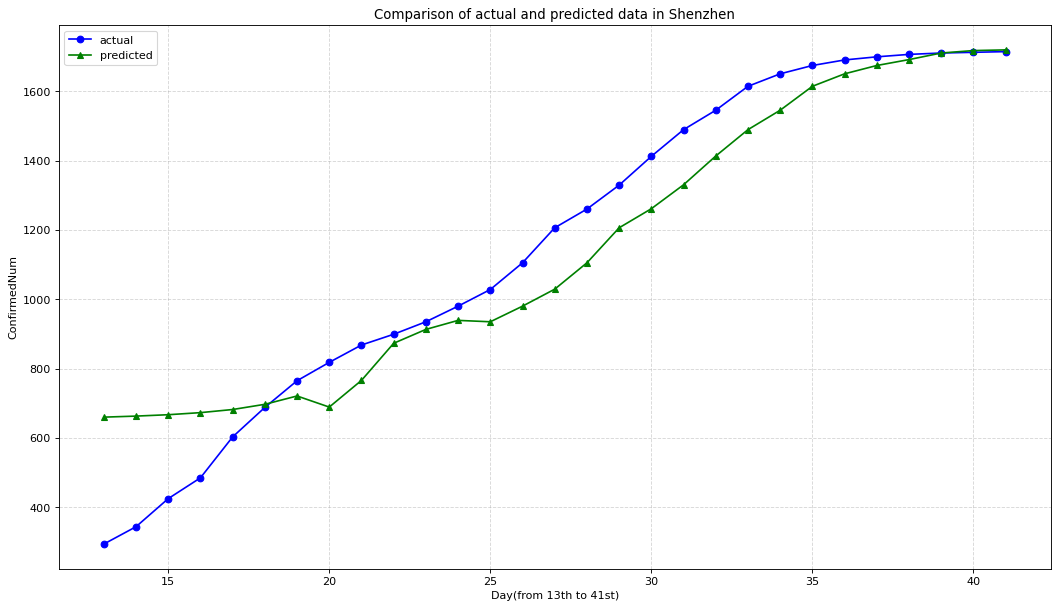

In [20]:
predict_shenzhen = list()
for i in range(0, 29):
    predict_shenzhen.append(math.ceil((predict_day(model_dict['shenzhen'],'shenzhen',shenzhen[i:i+TIMESTEP],shenzhen[i+TIMESTEP][1]))))
np_predict_shenzhen = np.array(predict_shenzhen).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shenzhen_data.csv" ,header=0)
true_shenzhen = list()
for i in range(0, 29):
    true_shenzhen.append(df.iloc[28 - i, 1])
np_true_shenzhen = np.array(true_shenzhen).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Shenzhen')
plt.plot(x, np_true_shenzhen, color='b', marker='o', label='actual')
plt.plot(x, np_predict_shenzhen, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

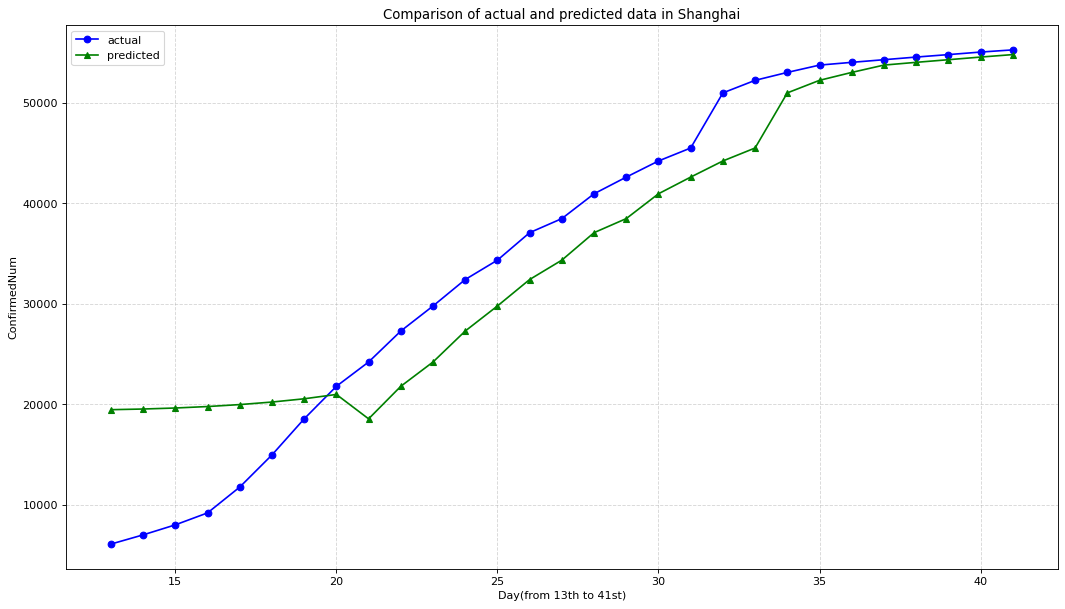

In [29]:
predict_shanghai = list()
for i in range(0, 29):
    predict_shanghai.append(math.ceil((predict_day(model_dict['shanghai'],'shanghai',shanghai[i:i+TIMESTEP],shanghai[i+TIMESTEP][1]))))
np_predict_shanghai = np.array(predict_shanghai).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shanghai_data.csv" ,header=0)
true_shanghai = list()
for i in range(0, 29):
    true_shanghai.append(df.iloc[28 - i, 1])
np_true_shanghai = np.array(true_shanghai).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Shanghai')
plt.plot(x, np_true_shanghai, color='b', marker='o', label='actual')
plt.plot(x, np_predict_shanghai, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

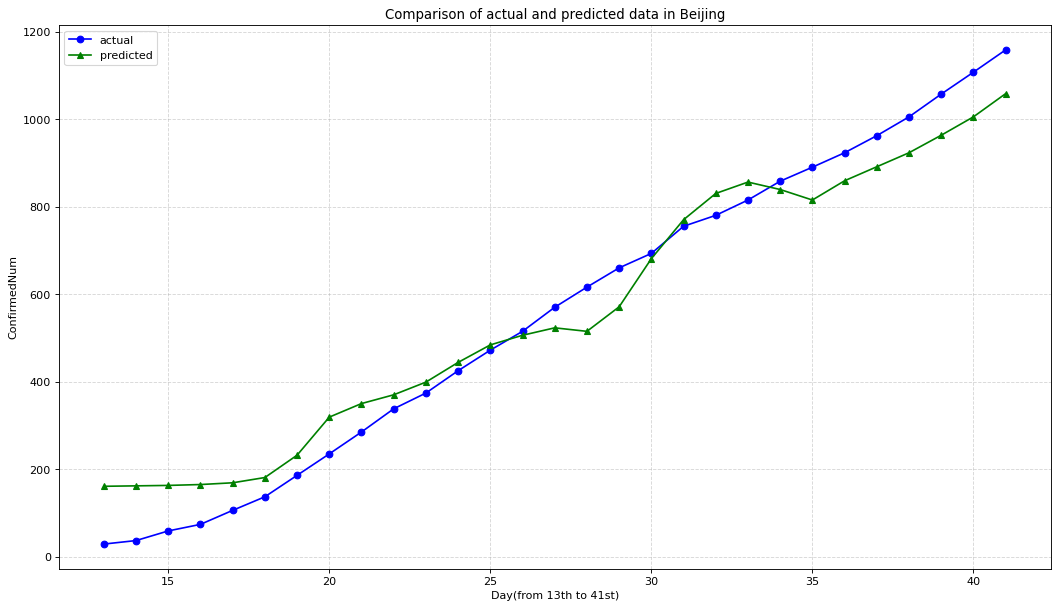

In [22]:
predict_beijing = list()
for i in range(0, 29):
    predict_beijing.append(math.ceil((predict_day(model_dict['beijing'],'beijing',beijing[i:i+TIMESTEP],beijing[i+TIMESTEP][1]))))
np_predict_beijing = np.array(predict_beijing).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/beijing_data.csv" ,header=0)
true_beijing = list()
for i in range(0, 29):
    true_beijing.append(df.iloc[28 - i, 1])
np_true_beijing = np.array(true_beijing).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Beijing')
plt.plot(x, np_true_beijing, color='b', marker='o', label='actual')
plt.plot(x, np_predict_beijing, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

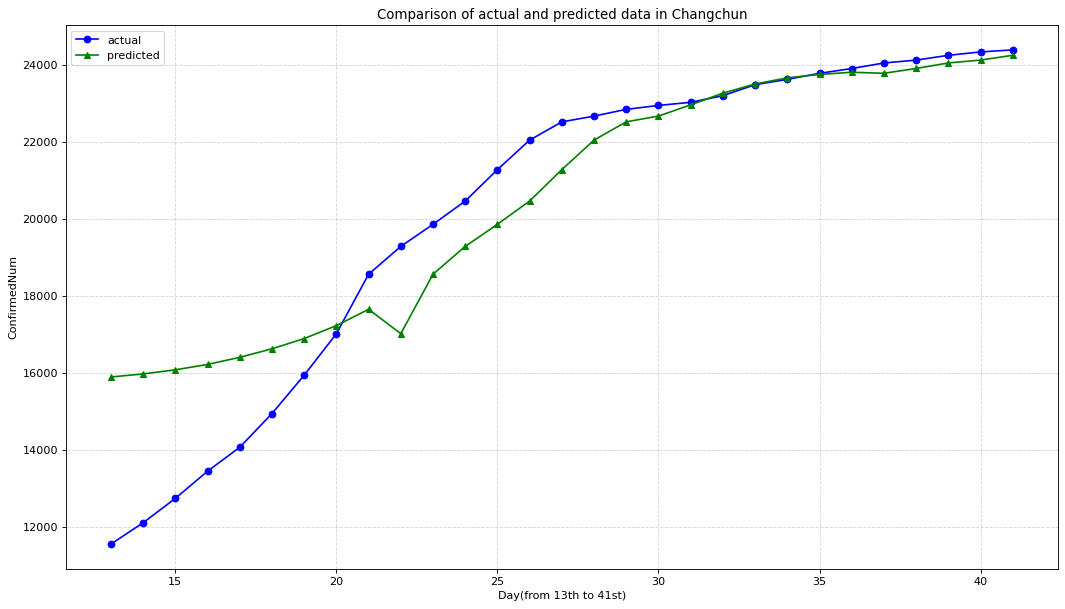

In [23]:
predict_changchun = list()
for i in range(0, 29):
    predict_changchun.append(math.ceil((predict_day(model_dict['changchun'],'changchun',changchun[i:i+TIMESTEP],changchun[i+TIMESTEP][1]))))
np_predict_changchun = np.array(predict_changchun).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/changchun_data.csv" ,header=0)
true_changchun = list()
for i in range(0, 29):
    true_changchun.append(df.iloc[28 - i, 1])
np_true_changchun = np.array(true_changchun).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Changchun')
plt.plot(x, np_true_changchun, color='b', marker='o', label='actual')
plt.plot(x, np_predict_changchun, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

In [24]:
def predict_new(model, name,days,min):
    model.eval()
    with torch.no_grad():
        x = days[:,0].reshape(1, -1).float()
        y = days[:,1].reshape(1, -1).float()
        attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
        y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
        # Does not output values that defy common sense.
        if y_pred < min:
            y_pred = y[0,-1]+0.01
        return y_pred.cpu().reshape(-1, 1)[0][0], scaler_dict[name].inverse_transform(y_pred.cpu().reshape(-1,1))[0][0]

[4048, 4054, 4060, 4067, 4073, 4079, 4086, 4092, 4098, 4104, 4111, 4117, 4123, 4130, 4136, 4142, 4149, 4155, 4161, 4167, 4174, 4180, 4186, 4193, 4199, 4205, 4212, 4218, 4224]


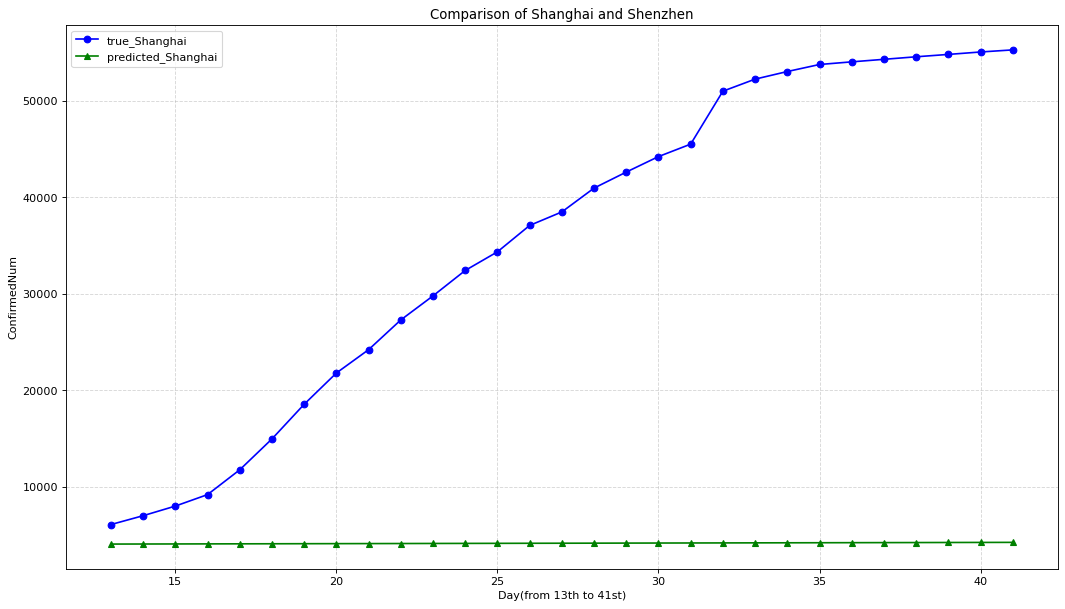

In [25]:

shanghai_numpy = shanghai.numpy()
shanghai_numpy = np.delete(shanghai_numpy, np.s_[-30:], axis=0)
predict_shanghai_through_shenzhen = list()
origin = scaler_dict['shanghai'].inverse_transform(shanghai_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shenzhen'].transform(origin)
shanghai_numpy[:,1] = origin.reshape(1,-1)[0]
for i in range(0, 29):
    shanghai_temp = torch.from_numpy(shanghai_numpy)
    not_inversed, inversed = predict_new(model_dict['shenzhen'],'shenzhen',shanghai_temp[i:i+TIMESTEP],shanghai_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    predict_shanghai_through_shenzhen.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    shanghai_numpy = np.append(shanghai_numpy, t, axis=0)
print(predict_shanghai_through_shenzhen)
np_predict_shanghai_through_shenzhen = np.array(predict_shanghai_through_shenzhen).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shanghai_data.csv" ,header=0)
true_shanghai = list()
for i in range(0, 29):
    true_shanghai.append(df.iloc[28 - i, 1])
np_true_shanghai = np.array(true_shanghai).reshape(-1, 1)
plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of Shanghai and Shenzhen')
plt.plot(x, np_true_shanghai, color='b', marker='o', label='true_Shanghai')
plt.plot(x, np_predict_shanghai_through_shenzhen, color='g', marker='^', label='predicted_Shanghai')
plt.legend()
plt.show()

[1551, 1585, 1615, 1640, 1660, 1678, 1691, 1701, 1707, 1709, 1709, 1707, 1706, 1701, 1699, 1697, 1696, 1695, 1694, 1694]
[47827, 48123, 49198, 49861, 51165, 52448, 51683, 49930, 46975, 43633, 40384, 38609, 35953, 34980, 34861, 34808, 34805, 34862, 35008, 35207]
[16828, 16897, 17132, 17381, 17749, 18267, 18940, 19456, 19922, 20379, 20757, 21147, 21621, 22128, 22169, 22213, 22252, 22292, 22324, 22349]


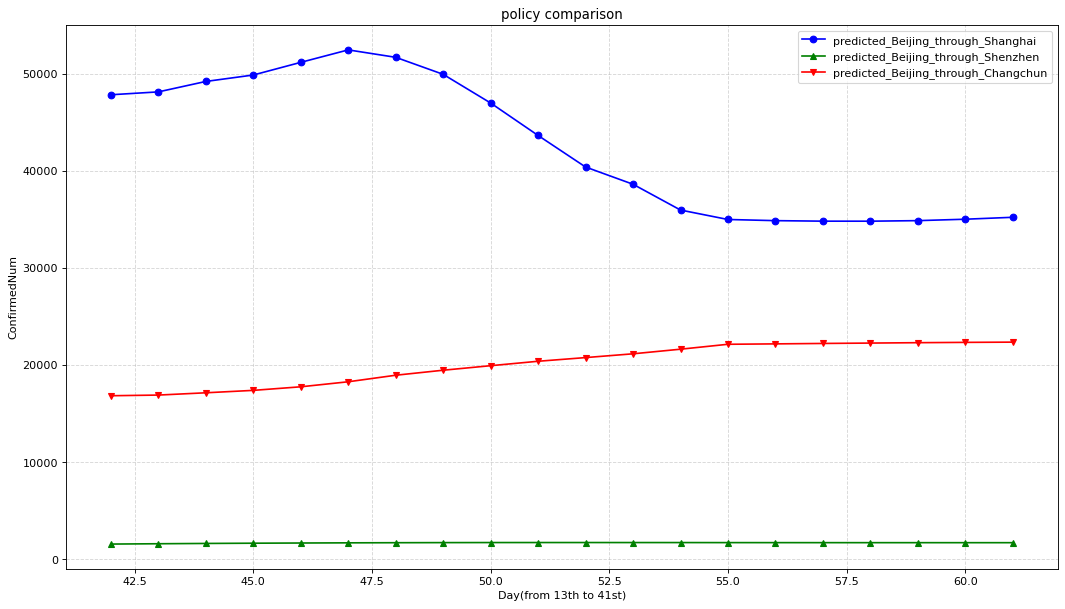

In [26]:
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shenzhen'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_shenzhen = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['shenzhen'],'shenzhen',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_shenzhen.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_shenzhen)
# print(beijing_numpy)
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shanghai'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_shanghai = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['shanghai'],'shanghai',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_shanghai.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_shanghai)
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['changchun'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_changchun = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['changchun'],'changchun',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_changchun.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_changchun)

np_predict_beijing_through_shenzhen = np.array(predict_beijing_through_shenzhen).reshape(-1, 1)
np_predict_beijing_through_shanghai = np.array(predict_beijing_through_shanghai).reshape(-1, 1)
np_predict_beijing_through_changchun = np.array(predict_beijing_through_changchun).reshape(-1, 1)
x = np.array([42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61]).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('policy comparison')
plt.plot(x, np_predict_beijing_through_shanghai, color='b', marker='o', label='predicted_Beijing_through_Shanghai')
plt.plot(x, np_predict_beijing_through_shenzhen, color='g', marker='^', label='predicted_Beijing_through_Shenzhen')
plt.plot(x, np_predict_beijing_through_changchun, color='r', marker='v', label='predicted_Beijing_through_Changchun')

plt.legend()
plt.show()